# 열수요 예측 데이터 전처리

## 목표
- 시계열 변수 생성 (년/월/일/시간/공휴일/계절)
- 정규화 (MinMaxScaler - 열수요와 시계열 변수 제외)
- 결측치 처리 (MICE 모델)
- 야간 일사량 0처리 (08시~18시 외)

---

## 1. 라이브러리 및 환경 설정

In [ ]:
# 필요한 라이브러리 설치  # MICE 호환성 # 공휴일 처리 # 시각화
!pip install scikit-learn==1.3.0 
!pip install holidays  
!pip install plotly   

In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

# 시계열 및 특징 생성
import holidays
from sklearn.preprocessing import MinMaxScaler

# 결측치 처리 (MICE)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# 설정
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)

print("✅ 라이브러리 설치 및 임포트 완료!")

✅ 라이브러리 설치 및 임포트 완료!


## 2. 데이터 로드 및 기본 탐색

In [2]:
# 데이터 로드 (파일명을 실제 데이터에 맞게 수정하세요)
file_path = 'train_heat.csv'  # 실제 파일명으로 변경
data = pd.read_csv(file_path)
# 첫 번째 열 제거 (Unnamed: 0)
data = data.drop(data.columns[0], axis=1)
# 컬럼명에서 'train_heat.' 접두사 제거
print("🔧 컬럼명 정리 중...")
print(f"   기존 컬럼명: {list(data.columns)}")

# 'train_heat.' 접두사 제거
data.columns = data.columns.str.replace('train_heat.', '', regex=False)

print(f"   변경된 컬럼명: {list(data.columns)}")

# branch_id를 A~S에서 1~19로 변경
print("🔧 branch_id 변환 중...")
if 'branch_id' in data.columns:
    # A~S를 1~19로 매핑
    branch_mapping = {chr(65+i): i+1 for i in range(19)}  # A=1, B=2, ..., S=19
    print(f"   변환 전 branch_id 값: {sorted(data['branch_id'].unique())}")
    data['branch_id'] = data['branch_id'].map(branch_mapping)
    print(f"   변환 후 branch_id 값: {sorted(data['branch_id'].unique())}")

print(f"📊 데이터 로드 완료: {data.shape}")

print(f"   행 수: {len(data):,}")
print(f"   열 수: {len(data.columns)}")
print(f"   메모리 사용량: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

🔧 컬럼명 정리 중...
   기존 컬럼명: ['train_heat.tm', 'train_heat.branch_id', 'train_heat.ta', 'train_heat.wd', 'train_heat.ws', 'train_heat.rn_day', 'train_heat.rn_hr1', 'train_heat.hm', 'train_heat.si', 'train_heat.ta_chi', 'train_heat.heat_demand']
   변경된 컬럼명: ['tm', 'branch_id', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']
🔧 branch_id 변환 중...
   변환 전 branch_id 값: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']
   변환 후 branch_id 값: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]
📊 데이터 로드 완료: (499301, 11)
   행 수: 499,301
   열 수: 11
   메모리 사용량: 41.90 MB


In [3]:
# 기본 정보 확인
print("📋 데이터 정보:")
print(data.info())

📋 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   tm           499301 non-null  int64  
 1   branch_id    499301 non-null  int64  
 2   ta           499301 non-null  float64
 3   wd           499301 non-null  float64
 4   ws           499301 non-null  float64
 5   rn_day       499301 non-null  float64
 6   rn_hr1       499301 non-null  float64
 7   hm           499301 non-null  float64
 8   si           499301 non-null  float64
 9   ta_chi       499301 non-null  float64
 10  heat_demand  499301 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 41.9 MB
None


In [4]:
# 기본 통계
print("📈 기본 통계:")
data.describe()

📈 기본 통계:


,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
count,4.993010e+05,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000
mean,2.022067e+09,10.000000,10.621007,194.322872,-2.344705,-1.843207,-3.649492,53.024052,-45.600886,13.869692,95.861923
std,8.172155e+05,5.477231,20.878917,118.348853,19.161911,21.340679,19.082926,49.080340,49.938291,11.888126,115.269280
min,2.021010e+09,1.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
25%,2.021100e+09,5.000000,4.400000,105.000000,0.500000,0.000000,0.000000,44.900000,-99.000000,4.400000,25.000000
50%,2.022070e+09,10.000000,14.200000,212.100000,1.100000,0.000000,0.000000,64.700000,0.000000,15.000000,55.000000
75%,2.023040e+09,15.000000,22.500000,294.300000,2.000000,0.000000,0.000000,82.500000,0.960000,24.300000,116.000000
max,2.023123e+09,19.000000,37.800000,360.000000,11.900000,326.500000,92.500000,100.000000,3.920000,37.100000,966.000000


# 2.1 -99값 Null로 변환 후 결측치 확인

In [5]:
# -99 값을 null로 변경 및 결측치 현황 확인
print("🔧 -99 값을 null로 변경 중...")

# 변경 전 -99 값 개수 확인
missing_99_before = (data == -99).sum().sum()
print(f"   변경 전 -99 값: {missing_99_before:,}개")

# -99를 NaN으로 변경
data = data.replace(-99, np.nan)

# 변경 후 -99 값 개수 확인
missing_99_after = (data == -99).sum().sum()
print(f"   변경 후 -99 값: {missing_99_after:,}개")
print(f"   변경된 값: {missing_99_before - missing_99_after:,}개")

print("\n🔍 결측치 현황:")
missing_info = data.isnull().sum()
missing_pct = (missing_info / len(data)) * 100

missing_df = pd.DataFrame({
    '결측치 개수': missing_info,
    '결측치 비율(%)': missing_pct
})

# 결측치가 있는 컬럼만 출력
missing_df = missing_df[missing_df['결측치 개수'] > 0]
if not missing_df.empty:
    print(missing_df.sort_values('결측치 비율(%)', ascending=False))
else:
    print("결측치가 없습니다.")

🔧 -99 값을 null로 변경 중...
   변경 전 -99 값: 361,089개
   변경 후 -99 값: 0개
   변경된 값: 361,089개

🔍 결측치 현황:
             결측치 개수  결측치 비율(%)
si           232922  46.649616
hm            39717   7.954520
rn_hr1        19154   3.836163
ws            18815   3.768268
wd            18815   3.768268
rn_day        18626   3.730415
ta            12997   2.603039
heat_demand      23   0.004606
ta_chi           20   0.004006


In [6]:
# 데이터 샘플 확인
print("🔍 데이터 샘플:")
data.head()

🔍 데이터 샘플:


,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
0,2021010101,1,-10.1,78.3,0.5,0.0,0.0,68.2,NaN,-8.2,281.0
1,2021010102,1,-10.2,71.9,0.6,0.0,0.0,69.9,NaN,-8.6,262.0
2,2021010103,1,-10.0,360.0,0.0,0.0,0.0,69.2,NaN,-8.8,266.0
3,2021010104,1,-9.3,155.9,0.5,0.0,0.0,65.0,NaN,-8.9,285.0
4,2021010105,1,-9.0,74.3,1.9,0.0,0.0,63.5,NaN,-9.2,283.0


## 3. 시계열 변수 생성
년/월/일/시간/공휴일/계절 변수를 생성합니다.

In [7]:
def create_time_features(df):
    """
    시계열 관련 특징 생성
    """
    df = df.copy()
    
    print("📅 시계열 변수 생성 중...")
    
    # tm 컬럼을 datetime으로 변환 (YYYYMMDDHH 형식 가정)
    print("   tm 컬럼을 datetime으로 변환 중...")
    df['tm'] = pd.to_datetime(df['tm'].astype(str), format='%Y%m%d%H')
    
    # 기본 시간 변수
    df['year'] = df['tm'].dt.year
    df['month'] = df['tm'].dt.month
    df['day'] = df['tm'].dt.day
    df['hour'] = df['tm'].dt.hour
    df['dayofweek'] = df['tm'].dt.dayofweek  # 0=월요일
    df['dayofyear'] = df['tm'].dt.dayofyear
    df['week'] = df['tm'].dt.isocalendar().week
    
    # 주말 여부
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # # 계절 (0: 겨울, 1: 봄, 2: 여름, 3: 가을)
    # def get_season(month):
    #     if month in [12, 1, 2]:
    #         return 0  # 겨울
    #     elif month in [3, 4, 5]:
    #         return 1  # 봄
    #     elif month in [6, 7, 8]:
    #         return 2  # 여름
    #     else:
    #         return 3  # 가을
    
    # df['season'] = df['month'].apply(get_season)
    
    # # 한국 공휴일 처리
    # print("🎌 한국 공휴일 정보 추가 중...")
    # korea_holidays = holidays.SouthKorea()
    
    # df['is_holiday'] = df['datetime'].dt.date.apply(
    #     lambda x: 1 if x in korea_holidays else 0
    # )
    
    # 시간대 구분 (난방 수요 패턴 기반)
    def get_time_period(hour):
        if 6 <= hour <= 9:
            return 0  # 아침 피크
        elif 10 <= hour <= 17:
            return 1  # 주간
        elif 18 <= hour <= 23:
            return 2  # 저녁 피크
        else:
            return 3  # 야간
    
    df['time_period'] = df['hour'].apply(get_time_period)
    
    # 난방/냉방 시즌 구분
    df['heating_season'] = df['month'].apply(
        lambda x: 1 if x in [10, 11, 12, 1, 2, 3, 4] else 0
    )
    
    # # 주기적 특징 (사인/코사인 변환) - 순환성 반영
    # df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    # df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    # df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    # df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    # df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    # df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # 생성된 시계열 변수 목록
    time_features = [
        'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'week',
        'is_weekend', 'time_period', 'heating_season'
    ]

    # time_features.append['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos']
    
    print(f"✅ 시계열 변수 {len(time_features)}개 생성 완료")
    print(f"   생성된 변수: {time_features}")
    
    return df, time_features

# 시계열 변수 생성 실행
data, time_features = create_time_features(data)

print("📋 데이터 정보:")
print(data.info())

📅 시계열 변수 생성 중...
   tm 컬럼을 datetime으로 변환 중...
✅ 시계열 변수 10개 생성 완료
   생성된 변수: ['year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'week', 'is_weekend', 'time_period', 'heating_season']
📋 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   tm              499301 non-null  datetime64[ns]
 1   branch_id       499301 non-null  int64         
 2   ta              486304 non-null  float64       
 3   wd              480486 non-null  float64       
 4   ws              480486 non-null  float64       
 5   rn_day          480675 non-null  float64       
 6   rn_hr1          480147 non-null  float64       
 7   hm              459584 non-null  float64       
 8   si              266379 non-null  float64       
 9   ta_chi          499281 non-null  float64       
 10  heat_demand     499278 non-null  float64       


In [8]:
# 생성된 시계열 변수 확인
print("🔍 시계열 변수 샘플:")
data[time_features].head()

🔍 시계열 변수 샘플:


,year,month,day,hour,dayofweek,dayofyear,week,is_weekend,time_period,heating_season
0,2021,1,1,1,4,1,53,0,3,1
1,2021,1,1,2,4,1,53,0,3,1
2,2021,1,1,3,4,1,53,0,3,1
3,2021,1,1,4,4,1,53,0,3,1
4,2021,1,1,5,4,1,53,0,3,1


In [9]:
# 시계열 변수 기본 통계
print("📊 시계열 변수 기본 통계:")
data[time_features].describe()

📊 시계열 변수 기본 통계:


,year,month,day,hour,dayofweek,dayofyear,week,is_weekend,time_period,heating_season
count,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.0,499301.000000,499301.000000,499301.000000
mean,2022.000038,6.526238,15.721108,11.500438,3.005442,183.006926,26.571597,0.286769,1.583279,0.580806
std,0.816490,3.447752,8.795954,6.921962,2.000480,105.362157,15.051049,0.452253,1.037476,0.493428
min,2021.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000
25%,2021.000000,4.000000,8.000000,6.000000,1.000000,92.000000,14.0,0.000000,1.000000,0.000000
50%,2022.000000,7.000000,16.000000,12.000000,3.000000,183.000000,27.0,0.000000,1.000000,1.000000
75%,2023.000000,10.000000,23.000000,18.000000,5.000000,274.000000,40.0,1.000000,2.000000,1.000000
max,2023.000000,12.000000,31.000000,23.000000,6.000000,365.000000,53.0,1.000000,3.000000,1.000000


# 야간 일사량(08시~18시 제외)을 0으로 처리

In [10]:
def handle_missing_values(df):
    """
    결측치 처리: 야간 일사량 0처리 + MICE
    """
    df = df.copy()
    
    print("🔍 결측치 처리 전 현황:")
    missing_before = df.isnull().sum()
    for col in df.columns:
        if missing_before[col] > 0:
            pct = (missing_before[col] / len(df)) * 100
            print(f"   {col}: {missing_before[col]:,}개 ({pct:.2f}%)")
    
    # 1. 야간 일사량 0 처리 (08시~18시 외)
    if 'si' in df.columns and 'hour' in df.columns:
        print("\n☀️ 일사량 야간시간 0 처리 중...")
        
        # 08시~18시 외의 시간은 일사량 0
        night_mask = ~df['hour'].between(8, 18)
        df.loc[night_mask, 'si'] = 0
        
        night_count = night_mask.sum()
        print(f"   야간시간 {night_count:,}개 → 일사량 0 설정")
    
    # 2. -99 값을 NaN으로 변환 (기상 데이터의 결측 표시)
    print("\n🔄 -99 값을 NaN으로 변환 중...")
    df = df.replace(-99, np.nan)
        
    return df

# 결측치 처리 준비
data = handle_missing_values(data)

🔍 결측치 처리 전 현황:
   ta: 12,997개 (2.60%)
   wd: 18,815개 (3.77%)
   ws: 18,815개 (3.77%)
   rn_day: 18,626개 (3.73%)
   rn_hr1: 19,154개 (3.84%)
   hm: 39,717개 (7.95%)
   si: 232,922개 (46.65%)
   ta_chi: 20개 (0.00%)
   heat_demand: 23개 (0.00%)

☀️ 일사량 야간시간 0 처리 중...
   야간시간 270,446개 → 일사량 0 설정

🔄 -99 값을 NaN으로 변환 중...


## 4. 정규화 (MinMaxScaler) , 다른 정규화 방법 검토 필요 (StandardScalar)
열수요와 시계열 변수를 제외한 수치형 변수만 정규화합니다.

In [11]:
def apply_normalization(df, time_features):
    """
    MinMaxScaler를 이용한 정규화 (열수요와 시계열 변수 제외)
    """
    df = df.copy()
    
    print("📏 정규화 대상 변수 식별 중...")
    
    # 정규화 제외할 변수들
    exclude_columns = ['heat_demand'] + time_features + ['tm'] + ['branch_id']
        
    # 수치형 변수 중 정규화 대상 식별
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    normalize_columns = [col for col in numeric_columns if col not in exclude_columns]
    
    print(f"📊 정규화 대상 변수 ({len(normalize_columns)}개):")
    for col in normalize_columns:
        print(f"   - {col}")
    
    # MinMaxScaler 적용  
    scaler = MinMaxScaler()
    
    if normalize_columns:
        print("⚙️ MinMaxScaler 적용 중...")
        
        # 정규화 전 통계
        print("\n📈 정규화 전 통계 (일부 변수):")
        print(df[normalize_columns[:5]].describe())
        
        # 정규화 실행
        df[normalize_columns] = scaler.fit_transform(df[normalize_columns])
        print("✅ 정규화 완료")
        
        # 정규화 후 통계
        print(f"\n📈 정규화 후 통계 (일부 변수):")
        print(df[normalize_columns[:5]].describe())
    else:
        print("⚠️ 정규화할 수치형 변수가 없습니다.")
    
    return df, scaler, normalize_columns

# 정규화 실행
data, scaler, normalize_columns = apply_normalization(data, time_features)

📏 정규화 대상 변수 식별 중...
📊 정규화 대상 변수 (8개):
   - ta
   - wd
   - ws
   - rn_day
   - rn_hr1
   - hm
   - si
   - ta_chi
⚙️ MinMaxScaler 적용 중...

📈 정규화 전 통계 (일부 변수):
                  ta             wd             ws         rn_day  \
count  486304.000000  480486.000000  480486.000000  480675.000000   
mean       13.550747     205.808888       1.440149       1.921587   
std        10.855174     105.137403       1.185264       9.649994   
min       -19.700000      -9.900000       0.000000       0.000000   
25%         5.200000     118.500000       0.500000       0.000000   
50%        14.700000     220.800000       1.200000       0.000000   
75%        22.700000     297.100000       2.100000       0.000000   
max        37.800000     360.000000      11.900000     326.500000   

              rn_hr1  
count  480147.000000  
mean        0.154225  
std         1.236777  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        92.500000  
✅ 정규화 완료

📈 

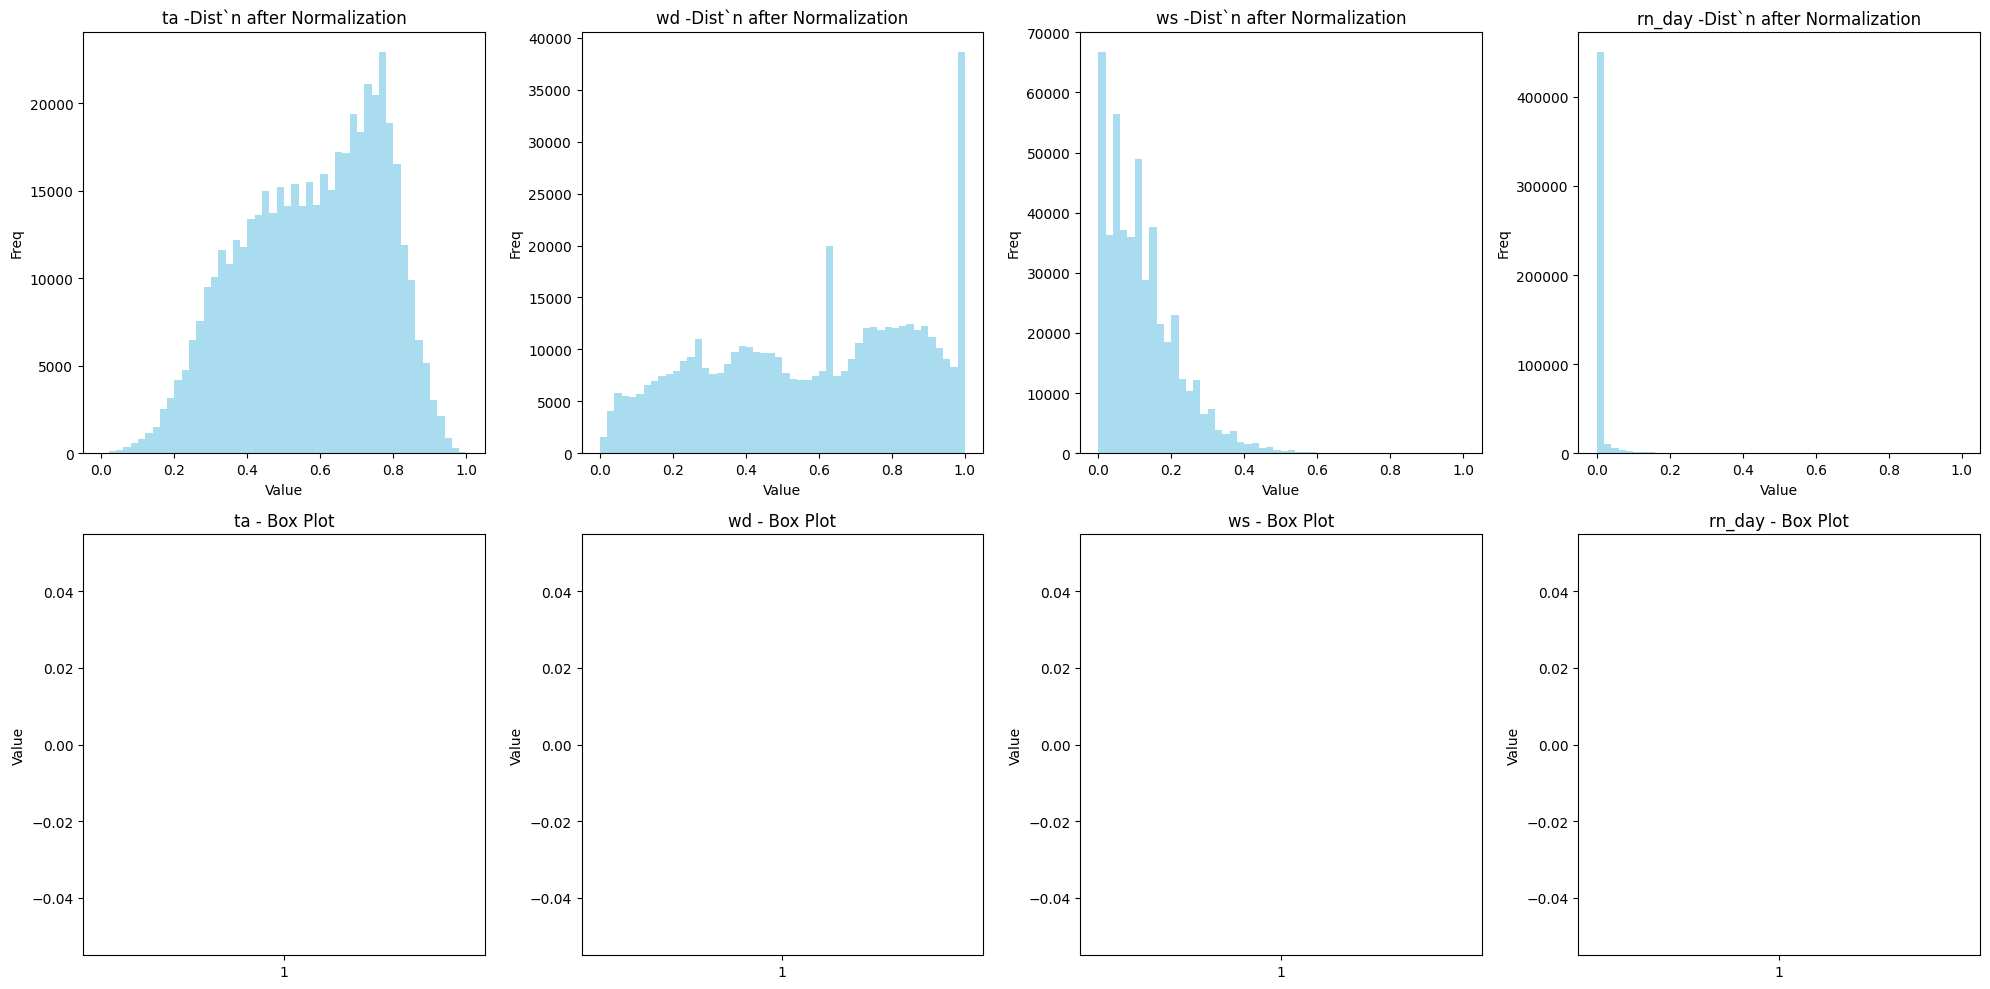

📊 정규화된 변수들의 분포를 확인했습니다.


In [12]:
# 정규화 결과 시각화 (선택적)
if normalize_columns:
    # 정규화된 변수들의 분포 확인
    n_cols = min(4, len(normalize_columns))
    fig, axes = plt.subplots(2, n_cols, figsize=(20, 10))
    
    for i, col in enumerate(normalize_columns[:n_cols]):
        if n_cols == 1:
            ax1, ax2 = axes[0], axes[1]
        else:
            ax1, ax2 = axes[0, i], axes[1, i]
        
        # 히스토그램
        ax1.hist(data[col], bins=50, alpha=0.7, color='skyblue')
        ax1.set_title(f'{col} -Dist`n after Normalization')
        ax1.set_xlabel('Value')
        ax1.set_ylabel('Freq')
        
        # 박스플롯
        ax2.boxplot(data[col])
        ax2.set_title(f'{col} - Box Plot')
        ax2.set_ylabel('Value')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 정규화된 변수들의 분포를 확인했습니다.")

## 5.1 Train/Test 분할 및 MICE 적용
결측치 처리가 완료된 데이터를 21~22년(train), 23년(test)로 분할하고 각각 MICE를 적용합니다.

In [13]:
# Train/Test 분할 및 MICE 적용 후 저장
print("🔧 Train/Test 분할 및 MICE 적용 시작...")

# # 1. 데이터 분할을 위한 연도 정보 확인
# print("\n📅 데이터 기간 확인...")
# if 'year' not in data.columns:
#     # year 컬럼이 없으면 생성
#     tm_column = None
#     for col in data.columns:
#         if 'tm' in col.lower():
#             tm_column = col
#             break
    
#     if tm_column:
#         data['datetime'] = pd.to_datetime(data[tm_column].astype(str), format='%Y%m%d%H')
#         data['year'] = data['datetime'].dt.year
#         print(f"   year 컬럼 생성 완료")
#     else:
#         print("   ⚠️ tm 컬럼을 찾을 수 없습니다.")

print(f"   데이터 기간: {data['year'].min()}년 ~ {data['year'].max()}년")
print(f"   연도별 데이터 개수:")
for year in sorted(data['year'].unique()):
    count = len(data[data['year'] == year])
    print(f"     {year}년: {count:,}개")

# 2. Train/Test 분할 (21~22년: train, 23년: test)
print("\n📊 Train/Test 분할 중...")

train_data = data[data['year'].isin([2021, 2022])].copy()
test_data = data[data['year'] == 2023].copy()

print(f"   Train set (2021-2022): {len(train_data):,}개 ({len(train_data)/len(data)*100:.1f}%)")
print(f"   Test set (2023): {len(test_data):,}개 ({len(test_data)/len(data)*100:.1f}%)")



🔧 Train/Test 분할 및 MICE 적용 시작...
   데이터 기간: 2021년 ~ 2023년
   연도별 데이터 개수:
     2021년: 166,421개
     2022년: 166,440개
     2023년: 166,440개

📊 Train/Test 분할 중...
   Train set (2021-2022): 332,861개 (66.7%)
   Test set (2023): 166,440개 (33.3%)


In [14]:
# 3. MICE 적용 전 결측치 현황 확인
print("\n🔍 MICE 적용 전 결측치 현황:")

# Train 결측치 현황
print("   [TRAIN]")
train_missing = train_data.isnull().sum()
train_total_missing = train_missing.sum()
print(f"     전체 결측치: {train_total_missing:,}개")
if train_total_missing > 0:
    for col in train_data.columns:
        if train_missing[col] > 0:
            pct = (train_missing[col] / len(train_data)) * 100
            print(f"       {col}: {train_missing[col]:,}개 ({pct:.2f}%)")

# Test 결측치 현황
print("   [TEST]")
test_missing = test_data.isnull().sum()
test_total_missing = test_missing.sum()
print(f"     전체 결측치: {test_total_missing:,}개")
if test_total_missing > 0:
    for col in test_data.columns:
        if test_missing[col] > 0:
            pct = (test_missing[col] / len(test_data)) * 100
            print(f"       {col}: {test_missing[col]:,}개 ({pct:.2f}%)")



🔍 MICE 적용 전 결측치 현황:
   [TRAIN]
     전체 결측치: 104,643개
       ta: 9,511개 (2.86%)
       wd: 11,013개 (3.31%)
       ws: 11,013개 (3.31%)
       rn_day: 14,180개 (4.26%)
       rn_hr1: 14,496개 (4.35%)
       hm: 36,077개 (10.84%)
       si: 8,319개 (2.50%)
       ta_chi: 18개 (0.01%)
       heat_demand: 16개 (0.00%)
   [TEST]
     전체 결측치: 32,224개
       ta: 3,486개 (2.09%)
       wd: 7,802개 (4.69%)
       ws: 7,802개 (4.69%)
       rn_day: 4,446개 (2.67%)
       rn_hr1: 4,658개 (2.80%)
       hm: 3,640개 (2.19%)
       si: 381개 (0.23%)
       ta_chi: 2개 (0.00%)
       heat_demand: 7개 (0.00%)


In [15]:
# 4. MICE 적용할 수치형 변수 선택
print("\n🐭 MICE 적용 대상 변수 선택...")

# 제외할 변수들 (ID, 시간 관련)
exclude_columns = ['tm'] # 'year' hour도 제외해야하나?
if 'tm' in train_data.columns:
    exclude_columns.append('tm')
# if 'branch_id' in train_data.columns: # branch id는 포함해야 지역 특성으로.
#     exclude_columns.append('branch_id')

# 수치형 변수 중 MICE 적용 대상 선택
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
mice_columns = [col for col in numeric_cols if col not in exclude_columns]

print(f"   MICE 적용 대상 변수 ({len(mice_columns)}개):")
for col in mice_columns:
    print(f"     - {col}")


🐭 MICE 적용 대상 변수 선택...
   MICE 적용 대상 변수 (20개):
     - branch_id
     - ta
     - wd
     - ws
     - rn_day
     - rn_hr1
     - hm
     - si
     - ta_chi
     - heat_demand
     - year
     - month
     - day
     - hour
     - dayofweek
     - dayofyear
     - week
     - is_weekend
     - time_period
     - heating_season


## 5.2 결측치 처리(MICE 적용)
MICE 모델을 사용하여 나머지 결측치를 처리합니다.
MICE도 지사별로 진행해야하지 않을까? 그렇다면 말도 안되게 Null이 많은 지사는 어떡할까?
현재 기준 MICE 40분째 진행되는 중(간소화 하는 방법 없을까? GPU 쓰게끔 수정하자!!!)

In [16]:
# 메모리 사용량 및 처리 시간 모니터링
import psutil
import time
    
process = psutil.Process()
memory_before = process.memory_info().rss / 1024 / 1024  # MB
start_time = time.time()
print(f"   📊 MICE 시작 전 메모리 사용량: {memory_before:.1f} MB")
print(f"   📊 처리할 데이터 크기: {train_data[mice_columns].shape}")

# 5. Train 데이터 MICE 적용
if len(mice_columns) > 0 and train_total_missing > 0:
    print("\n⚙️ === TRAIN 데이터 MICE 적용 ===")
    print("   ⚠️ 시간이 많이 소요될 수 있습니다...")
    
    # MICE 설정 (RandomForest 기반)
    mice_imputer_train = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=50, random_state=42),
        max_iter=3,  # 반복 횟수, 일단 3으로 두고 테스트트
        random_state=42,
        verbose=1
    )
        
    
    try:
        print("   🔄 MICE 모델 학습 및 적용 중...")
        mice_data_train = mice_imputer_train.fit_transform(train_data[mice_columns])
        train_data[mice_columns] = mice_data_train
        print("   ✅ Train MICE 완료")
        
    except Exception as e:
        print(f"   ❌ Train MICE 실패: {str(e)}")
        raise e
        
        # # MICE 실패 시 단순 보간
        # for col in mice_columns:
        #     if train_data[col].isnull().sum() > 0:
        #         train_data[col].fillna(train_data[col].median(), inplace=True)
        # print("   ✅ Train 단순 보간 완료")

else:
    print("\n⚠️ Train 데이터에 MICE 적용할 결측치가 없습니다.")

# 메모리 사용량 및 처리 시간 측정
memory_after = process.memory_info().rss / 1024 / 1024  # MB
end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n📊 MICE 처리 완료 - 성능 정보:")
print(f"   ⏱️ 소요 시간: {elapsed_time/60:.1f}분 ({elapsed_time:.1f}초)")
print(f"   💾 메모리 사용량: {memory_after:.1f} MB (증가: {memory_after-memory_before:+.1f} MB)")

   📊 MICE 시작 전 메모리 사용량: 525.0 MB
   📊 처리할 데이터 크기: (332861, 20)

⚙️ === TRAIN 데이터 MICE 적용 ===
   ⚠️ 시간이 많이 소요될 수 있습니다...
   🔄 MICE 모델 학습 및 적용 중...
[IterativeImputer] Completing matrix with shape (332861, 20)
[IterativeImputer] Change: 93.2075659841668, scaled tolerance: 2.0220000000000002 
[IterativeImputer] Change: 2.379999999999999, scaled tolerance: 2.0220000000000002 
[IterativeImputer] Change: 4.486388129174647, scaled tolerance: 2.0220000000000002 
   ✅ Train MICE 완료

📊 MICE 처리 완료 - 성능 정보:
   ⏱️ 소요 시간: 387.7분 (23261.7초)
   💾 메모리 사용량: 10951.3 MB (증가: +10426.4 MB)


In [17]:
# 메모리 사용량 및 처리 시간 모니터링
process = psutil.Process()
memory_before = process.memory_info().rss / 1024 / 1024  # MB
start_time = time.time()
print(f"   📊 MICE 시작 전 메모리 사용량: {memory_before:.1f} MB")
print(f"   📊 처리할 데이터 크기: {train_data[mice_columns].shape}")

# 6. Test 데이터 MICE 적용
if len(mice_columns) > 0 and test_total_missing > 0:
    print("\n⚙️ === TEST 데이터 MICE 적용 ===")
    print("   ⚠️ 시간이 많이 소요될 수 있습니다...")
    
    # MICE 설정 (RandomForest 기반)
    mice_imputer_test = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=50, random_state=42),
        max_iter=3,  # 반복 횟수
        random_state=42,
        verbose=1
    )
    
    try:
        print("   🔄 MICE 모델 학습 및 적용 중...")
        mice_data_test = mice_imputer_test.fit_transform(test_data[mice_columns])
        test_data[mice_columns] = mice_data_test
        print("   ✅ Test MICE 완료")
        
    except Exception as e:
        print(f"   ❌ Train MICE 실패: {str(e)}")
        raise e
        
        # # MICE 실패 시 단순 보간
        # for col in mice_columns:
        #     if train_data[col].isnull().sum() > 0:
        #         train_data[col].fillna(train_data[col].median(), inplace=True)
        # print("   ✅ Train 단순 보간 완료")

else:
    print("\n⚠️ Test 데이터에 MICE 적용할 결측치가 없습니다.")

# 메모리 사용량 및 처리 시간 측정
memory_after = process.memory_info().rss / 1024 / 1024  # MB
end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n📊 MICE 처리 완료 - 성능 정보:")
print(f"   ⏱️ 소요 시간: {elapsed_time/60:.1f}분 ({elapsed_time:.1f}초)")
print(f"   💾 메모리 사용량: {memory_after:.1f} MB (증가: {memory_after-memory_before:+.1f} MB)")

   📊 MICE 시작 전 메모리 사용량: 10959.2 MB
   📊 처리할 데이터 크기: (332861, 20)

⚙️ === TEST 데이터 MICE 적용 ===
   ⚠️ 시간이 많이 소요될 수 있습니다...
   🔄 MICE 모델 학습 및 적용 중...
   ✅ Test MICE 완료

📊 MICE 처리 완료 - 성능 정보:
   ⏱️ 소요 시간: 0.0분 (2.3초)
   💾 메모리 사용량: 11038.4 MB (증가: +79.2 MB)


In [18]:
# 7. MICE 적용 후 결측치 확인
print("\n📊 MICE 적용 후 결측치 현황:")

# Train 결측치 확인
train_missing_after = train_data.isnull().sum()
train_total_missing_after = train_missing_after.sum()
print(f"   [TRAIN] 남은 결측치: {train_total_missing_after:,}개")
if train_total_missing_after > 0:
    for col in train_data.columns:
        if train_missing_after[col] > 0:
            pct = (train_missing_after[col] / len(train_data)) * 100
            print(f"     {col}: {train_missing_after[col]:,}개 ({pct:.2f}%)")

# Test 결측치 확인
test_missing_after = test_data.isnull().sum()
test_total_missing_after = test_missing_after.sum()
print(f"   [TEST] 남은 결측치: {test_total_missing_after:,}개")
if test_total_missing_after > 0:
    for col in test_data.columns:
        if test_missing_after[col] > 0:
            pct = (test_missing_after[col] / len(test_data)) * 100
            print(f"     {col}: {test_missing_after[col]:,}개 ({pct:.2f}%)")


📊 MICE 적용 후 결측치 현황:
   [TRAIN] 남은 결측치: 0개
   [TEST] 남은 결측치: 0개


## 6. 전처리 결과 확인 및 저장

In [19]:
# 8. CSV 파일로 저장
print("\n💾 데이터 저장 중...")

# 파일명 생성
train_filename = 'train_data_mice.csv'
test_filename = 'test_data_mice.csv'

# Train 데이터 저장
train_data.to_csv(train_filename, index=False)
print(f"   ✅ Train 데이터 저장: {train_filename}")
print(f"      크기: {train_data.shape}")
print(f"      메모리: {train_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Test 데이터 저장
test_data.to_csv(test_filename, index=False)
print(f"   ✅ Test 데이터 저장: {test_filename}")
print(f"      크기: {test_data.shape}")
print(f"      메모리: {test_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 변수 목록도 별도 저장
variable_info = {
    'time_features': time_features,
    'normalize_columns': normalize_columns,
    'mice_columns': mice_columns,
    'total_columns': list(data.columns)
}

import json
with open('variable_info.json', 'w', encoding='utf-8') as f:
    json.dump(variable_info, f, ensure_ascii=False, indent=2)

print("📝 변수 정보 저장 완료: variable_info.json")


💾 데이터 저장 중...
   ✅ Train 데이터 저장: train_data_mice.csv
      크기: (332861, 21)
      메모리: 55.87 MB
   ✅ Test 데이터 저장: test_data_mice.csv
      크기: (166440, 21)
      메모리: 27.94 MB
📝 변수 정보 저장 완료: variable_info.json


In [20]:
# 9. 최종 요약
print("\n🎉 === 작업 완료 ===")
print(f"📊 최종 결과:")
print(f"   Train 데이터: {train_data.shape} → {train_filename}")
print(f"   Test 데이터: {test_data.shape} → {test_filename}")
print(f"   Train 결측치: {train_total_missing:,}개 → {train_total_missing_after:,}개")
print(f"   Test 결측치: {test_total_missing:,}개 → {test_total_missing_after:,}개")

# 데이터 샘플 확인
print(f"\n🔍 저장된 데이터 샘플:")
print("   [TRAIN] 처음 5행:")
print(train_data.head())
print("\n   [TEST] 처음 5행:")
print(test_data.head())

print(f"\n🚀 다음 단계: 시계열 변수 생성 및 정규화 진행 가능!")


🎉 === 작업 완료 ===
📊 최종 결과:
   Train 데이터: (332861, 21) → train_data_mice.csv
   Test 데이터: (166440, 21) → test_data_mice.csv
   Train 결측치: 104,643개 → 0개
   Test 결측치: 32,224개 → 0개

🔍 저장된 데이터 샘플:
   [TRAIN] 처음 5행:
                   tm  branch_id        ta        wd        ws  rn_day  \
0 2021-01-01 01:00:00        1.0  0.166957  0.238443  0.042017     0.0   
1 2021-01-01 02:00:00        1.0  0.165217  0.221141  0.050420     0.0   
2 2021-01-01 03:00:00        1.0  0.168696  1.000000  0.000000     0.0   
3 2021-01-01 04:00:00        1.0  0.180870  0.448229  0.042017     0.0   
4 2021-01-01 05:00:00        1.0  0.186087  0.227629  0.159664     0.0   

   rn_hr1        hm   si    ta_chi  heat_demand    year  month  day  hour  \
0     0.0  0.673846  0.0  0.266990        281.0  2021.0    1.0  1.0   1.0   
1     0.0  0.691282  0.0  0.260518        262.0  2021.0    1.0  1.0   2.0   
2     0.0  0.684103  0.0  0.257282        266.0  2021.0    1.0  1.0   3.0   
3     0.0  0.641026  0.0  0.255663    

In [21]:
# 주요 변수들의 기본 통계
print("📊 주요 변수 기본 통계:")

# 열수요 변수 (타겟)
if 'heat_demand' in data.columns:
    print("\n🎯 열수요 (타겟 변수):")
    print(data['heat_demand'].describe())

# 온도 관련 변수
temp_cols = [col for col in ['ta', 'ta_chi'] if col in data.columns]
if temp_cols:
    print("\n🌡️ 온도 관련 변수:")
    print(data[temp_cols].describe())

# 시계열 변수
print("\n⏰ 시계열 변수 (일부):")
print(data[time_features[:8]].describe())

📊 주요 변수 기본 통계:

🎯 열수요 (타겟 변수):
count    499278.000000
mean         95.870900
std         115.264347
min           0.000000
25%          25.000000
50%          55.000000
75%         116.000000
max         966.000000
Name: heat_demand, dtype: float64

🌡️ 온도 관련 변수:
                  ta         ta_chi
count  486304.000000  499281.000000
mean        0.578274       0.624178
std         0.188786       0.192021
min         0.000000       0.000000
25%         0.433043       0.470874
50%         0.598261       0.642395
75%         0.737391       0.792880
max         1.000000       1.000000

⏰ 시계열 변수 (일부):
                year          month            day           hour  \
count  499301.000000  499301.000000  499301.000000  499301.000000   
mean     2022.000038       6.526238      15.721108      11.500438   
std         0.816490       3.447752       8.795954       6.921962   
min      2021.000000       1.000000       1.000000       0.000000   
25%      2021.000000       4.000000       8.000000  

## 7. 전처리 요약

### 완료된 작업:

1. **시계열 변수 생성** ✅
   - 기본 시간 변수: year, month, day, hour, dayofweek, dayofyear, week
   - 파생 변수: is_weekend, season, is_holiday, time_period, heating_season
   - 순환 변수: hour_sin/cos, month_sin/cos, dayofweek_sin/cos

2. **정규화 (MinMaxScaler)** ✅
   - 열수요와 시계열 변수를 제외한 수치형 변수만 정규화
   - 0~1 범위로 스케일링

3. **결측치 처리** ✅
   - 야간 일사량 0 처리 (08시~18시 외)
   - MICE 모델을 사용한 결측치 보간
   - -99 값을 NaN으로 변환 후 처리

### 다음 단계:
- 모델링 (AutoML, 전통적 ML 등)
- 교차검증 및 성능 평가
- 특성 중요도 분석
- 하이퍼파라미터 튜닝

In [22]:
# 9. 최종 요약
print("\n🎉 === 작업 완료 ===")
print(f"📊 최종 결과:")
print(f"   Train 데이터: {train_data.shape} → {train_filename}")
print(f"   Test 데이터: {test_data.shape} → {test_filename}")
print(f"   Train 결측치: {train_total_missing:,}개 → {train_total_missing_after:,}개")
print(f"   Test 결측치: {test_total_missing:,}개 → {test_total_missing_after:,}개")

# 데이터 샘플 확인
print(f"\n🔍 저장된 데이터 샘플:")
print("   [TRAIN] 처음 5행:")
print(train_data.head())
print("\n   [TEST] 처음 5행:")
print(test_data.head())

print(f"\n🚀 다음 단계: 시계열 변수 생성 및 정규화 진행 가능!")


🎉 === 작업 완료 ===
📊 최종 결과:
   Train 데이터: (332861, 21) → train_data_mice.csv
   Test 데이터: (166440, 21) → test_data_mice.csv
   Train 결측치: 104,643개 → 0개
   Test 결측치: 32,224개 → 0개

🔍 저장된 데이터 샘플:
   [TRAIN] 처음 5행:
                   tm  branch_id        ta        wd        ws  rn_day  \
0 2021-01-01 01:00:00        1.0  0.166957  0.238443  0.042017     0.0   
1 2021-01-01 02:00:00        1.0  0.165217  0.221141  0.050420     0.0   
2 2021-01-01 03:00:00        1.0  0.168696  1.000000  0.000000     0.0   
3 2021-01-01 04:00:00        1.0  0.180870  0.448229  0.042017     0.0   
4 2021-01-01 05:00:00        1.0  0.186087  0.227629  0.159664     0.0   

   rn_hr1        hm   si    ta_chi  heat_demand    year  month  day  hour  \
0     0.0  0.673846  0.0  0.266990        281.0  2021.0    1.0  1.0   1.0   
1     0.0  0.691282  0.0  0.260518        262.0  2021.0    1.0  1.0   2.0   
2     0.0  0.684103  0.0  0.257282        266.0  2021.0    1.0  1.0   3.0   
3     0.0  0.641026  0.0  0.255663    